<a href="https://www.kaggle.com/code/veramikhalchenko/emnist-cnns-architectures-mikhalchenko?scriptVersionId=180407381" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**CNN's Architectures**\
Conduct experiments on the initial training of different models and compare the results.

Take the EMNIST dataset from torchvision.\
Train models on it: ResNet 18, VGG 16, Inception v3, DenseNet 161:
it is advisable to train each model from scratch for 10 epochs.\
If there are not enough computer / Colab resources, it is enough to train each model for 1-2 epochs.\
Summarize the results of training models (loss plots) in a table and compare them.

In [128]:
 !pip install torchsummary

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import os

import torch
import torch.nn as nn
import torchvision as tv
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import Compose,ToTensor, Resize, Normalize
from torchvision.transforms import ToPILImage, Grayscale, CenterCrop
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import time

In [130]:
batch_size = 256

**Data loading**

In [131]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emnist/emnist-letters-mapping.txt
/kaggle/input/emnist/emnist-letters-test.csv
/kaggle/input/emnist/emnist-mnist-mapping.txt
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-bymerge-mapping.txt
/kaggle/input/emnist/emnist-balanced-train.csv
/kaggle/input/emnist/emnist-digits-test.csv
/kaggle/input/emnist/emnist-balanced-test.csv
/kaggle/input/emnist/emnist-mnist-test.csv
/kaggle/input/emnist/emnist-letters-train.csv
/kaggle/input/emnist/emnist-byclass-train.csv
/kaggle/input/emnist/emnist-bymerge-test.csv
/kaggle/input/emnist/emnist-balanced-mapping.txt
/kaggle/input/emnist/emnist-mnist-train.csv
/kaggle/input/emnist/emnist-digits-mapping.txt
/kaggle/input/emnist/emnist-bymerge-train.csv
/kaggle/input/emnist/emnist-byclass-test.csv
/kaggle/input/emnist/emnist-byclass-mapping.txt
/kaggle/input/emnist/emnist_source_files/emnist-digits-test-labels-idx1-ubyte
/kaggle/input/emnist/emnist_source_files/emnist-bymerge-train-labels-idx1-ubyte
/kaggle/input/

In [132]:
#Reading using pandas
train_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
class EMNISTDataset(Dataset):
    
    def __init__(self, image_data_path, mapping_data_path, 
                 transform = None, target_transform = None):
        
        self.image_data_df = pd.read_csv(image_data_path,  header = None)
        self.label_map = pd.read_csv(mapping_data_path, delimiter = '\t')
        self.transform = self.create_transform()
        
        label_map = pd.read_csv(mapping_data_path, 
                                delimiter = ' ', 
                                index_col=0, 
                                header=None
                               ).squeeze()
        #Initialising an empty dictionary
        label_dictionary = {}
        #Running a loop for ASCII equivalent to character conversion
        for index, label in enumerate(label_map):
            label_dictionary[index] = chr(label)
        self.label_dictionary = label_dictionary

    def __getitem__(self, idx):
        
        sample_row = self.image_data_df.iloc[idx] 
        sample_label = sample_row[0]
        W = 28
        H = 28
        sample_img = sample_row[1:].values.reshape(W, H).astype(np.float32)
        sample_label = sample_label
        sample_img = self.transform(sample_img)
        
        return sample_img, sample_label
        
    def __len__(self):
        
        return self.image_data_df.shape[0]
    
    
    def create_transform(self):
        
        transforms = Compose([
        ToPILImage(),
        Grayscale(3),
        Resize((224,224)),
        ToTensor()
        ])

        return transforms

In [134]:
training_data_path = '/kaggle/input/emnist/emnist-balanced-train.csv'
test_data_path = '/kaggle/input/emnist/emnist-balanced-test.csv'
mapping_data_path = '/kaggle/input/emnist/emnist-balanced-mapping.txt'

training_data = EMNISTDataset(image_data_path = training_data_path,
                              mapping_data_path = mapping_data_path, 
                              transform = None, 
                              target_transform = None)
test_data = EMNISTDataset(image_data_path = test_data_path,  
                          mapping_data_path = mapping_data_path, 
                          transform = None, 
                          target_transform = None)

In [135]:
train_data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

**Check device**

In [138]:
device = ('cuda' if torch.cuda.is_available() else 'cpu' 
print(f'Using {device} device')

Using cuda device


**Data analysis**

In [141]:
def class_dist(dataset):
    '''The function plots the class distribution'''
    res = {}
    
    for X, y in dataset:
        if y in res:
            res[y] += 1            
        else:
            res[y] = 1
   
    print(f'Num of Classes {len(res)}')
    plt.bar(res.keys(), res.values())
    plt.title('Distribution of Classes')
    plt.show()

Num of Classes 47


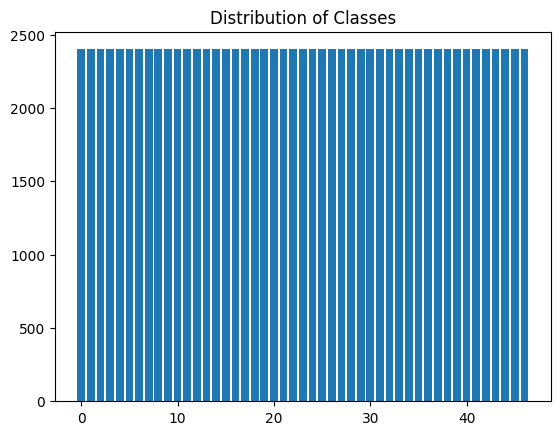

In [142]:
class_dist(training_data)

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


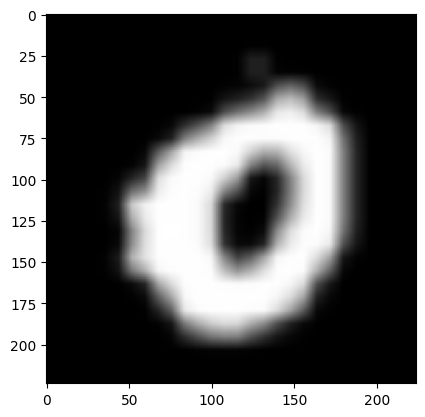

Label: 0


In [144]:
# Display image and label.
train_features, train_labels = next(iter(train_data_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0][2:3].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

In [145]:
for X, y in train_data_loader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 224, 224])
Shape of y: torch.Size([256]) torch.int64


**Models import**

In [247]:
model_resnet18 = tv.models.resnet18(weights=None)
model_vgg16 = tv.models.vgg16(weights=None)
model_densenet161 = tv.models.densenet161(weights=None)

In [147]:
def update_params(net):
    
    params_to_update = []
    for name, param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    
    return params_to_update

In [148]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    
    return acc_sum.item() / n

In [210]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    
    train_loss_history = []
    net.to(device)
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            train_loss_history.append(train_l_sum / n)
            
            if i % 10 == 0:
                print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                        f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))   
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        
    return train_loss_history

**ResNet 18**

In [150]:
summary(model_resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [151]:
for param in model_resnet18.parameters():
    param.requires_grad = False

In [152]:
model_resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [153]:
model_resnet18.fc = nn.Linear(in_features=512, out_features=47)

In [154]:
params_to_update = update_params(model_resnet18)

In [155]:
loss = nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.NAdam(params_to_update, lr=0.001)

In [156]:
tr_loss_resnet18 = train(model_resnet18, 
                         train_data_loader, test_data_loader, 
                         trainer, 10)

Step 0. time since epoch: 0.549. Train acc: 0.020. Train Loss: 3.930
Step 10. time since epoch: 5.476. Train acc: 0.027. Train Loss: 3.874
Step 20. time since epoch: 10.434. Train acc: 0.032. Train Loss: 3.852
Step 30. time since epoch: 15.410. Train acc: 0.040. Train Loss: 3.826
Step 40. time since epoch: 20.499. Train acc: 0.043. Train Loss: 3.804
Step 50. time since epoch: 25.476. Train acc: 0.046. Train Loss: 3.784
Step 60. time since epoch: 30.489. Train acc: 0.050. Train Loss: 3.765
Step 70. time since epoch: 35.439. Train acc: 0.053. Train Loss: 3.744
Step 80. time since epoch: 40.417. Train acc: 0.055. Train Loss: 3.727
Step 90. time since epoch: 45.403. Train acc: 0.058. Train Loss: 3.711
Step 100. time since epoch: 50.409. Train acc: 0.061. Train Loss: 3.694
Step 110. time since epoch: 55.528. Train acc: 0.062. Train Loss: 3.679
Step 120. time since epoch: 60.550. Train acc: 0.064. Train Loss: 3.668
Step 130. time since epoch: 65.528. Train acc: 0.066. Train Loss: 3.654
Step 

**VGG 16**

In [157]:
summary(model_vgg16.to(device), input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [158]:
for param in model_vgg16.parameters():
    param.requires_grad = False

In [159]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [246]:
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=47, bias=True)


In [161]:
params_to_update = update_params(model_vgg16)
params_to_update

[Parameter containing:
 tensor([[-0.0033,  0.0041,  0.0036,  ..., -0.0030,  0.0028, -0.0045],
         [-0.0049, -0.0017, -0.0023,  ...,  0.0035,  0.0009,  0.0042],
         [-0.0016, -0.0043, -0.0026,  ...,  0.0001, -0.0043, -0.0031],
         ...,
         [-0.0034,  0.0019,  0.0047,  ..., -0.0040, -0.0024, -0.0017],
         [ 0.0063,  0.0032, -0.0006,  ...,  0.0048, -0.0009, -0.0023],
         [ 0.0054, -0.0040, -0.0051,  ..., -0.0018, -0.0046, -0.0006]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0063, -0.0044,  0.0029,  ..., -0.0011,  0.0049, -0.0025],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0128,  0.0116,  0.0040,  ..., -0.0080,  0.0071,  0.0057],
         [-0.0116, -0.0032, -0.0069,  ...,  0.0059, -0.0094, -0.0010],
         [ 0.0039,  0.0079, -0.0083,  ..., -0.0133, -0.0038,  0.0133],
         ...,
         [-0.0102,  0.0129, -0.0015,  ...,  0.0152, -0.0083,  0.0034],
         [ 0.0082,  0.0141,  0.0024,  ..., -0.0051,  0.0128, -0.

In [162]:
loss = nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.NAdam(params_to_update, lr=0.001)

In [163]:
tr_loss_vgg16 = train(model_vgg16, 
                      train_data_loader, test_data_loader, 
                      trainer, 10)

Step 0. time since epoch: 0.974. Train acc: 0.016. Train Loss: 3.851
Step 10. time since epoch: 10.599. Train acc: 0.045. Train Loss: 3.811
Step 20. time since epoch: 20.204. Train acc: 0.066. Train Loss: 3.692
Step 30. time since epoch: 29.908. Train acc: 0.092. Train Loss: 3.509
Step 40. time since epoch: 39.568. Train acc: 0.123. Train Loss: 3.317
Step 50. time since epoch: 49.139. Train acc: 0.152. Train Loss: 3.165
Step 60. time since epoch: 58.777. Train acc: 0.185. Train Loss: 2.996
Step 70. time since epoch: 68.418. Train acc: 0.215. Train Loss: 2.848
Step 80. time since epoch: 77.987. Train acc: 0.243. Train Loss: 2.721
Step 90. time since epoch: 87.690. Train acc: 0.269. Train Loss: 2.604
Step 100. time since epoch: 97.357. Train acc: 0.294. Train Loss: 2.501
Step 110. time since epoch: 106.982. Train acc: 0.314. Train Loss: 2.414
Step 120. time since epoch: 116.655. Train acc: 0.334. Train Loss: 2.334
Step 130. time since epoch: 126.306. Train acc: 0.352. Train Loss: 2.261
S

**Dense Net 161**

In [164]:
model_densenet161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [165]:
for param in model_densenet161.parameters():
    param.requires_grad = False

In [166]:
model_densenet161.classifier = nn.Linear(in_features=2208, 
                                         out_features=47)

In [167]:
params_to_update = update_params(model_densenet161)

In [168]:
loss = nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.NAdam(params_to_update, lr=0.001)

In [169]:
tr_loss_densenet161 = train(model_densenet161,
                            train_data_loader, test_data_loader, 
                            trainer, 10)

Step 0. time since epoch: 1.358. Train acc: 0.027. Train Loss: 3.887
Step 10. time since epoch: 14.949. Train acc: 0.029. Train Loss: 3.858
Step 20. time since epoch: 28.448. Train acc: 0.050. Train Loss: 3.775
Step 30. time since epoch: 42.023. Train acc: 0.060. Train Loss: 3.710
Step 40. time since epoch: 55.506. Train acc: 0.070. Train Loss: 3.653
Step 50. time since epoch: 69.084. Train acc: 0.077. Train Loss: 3.608
Step 60. time since epoch: 82.611. Train acc: 0.084. Train Loss: 3.566
Step 70. time since epoch: 96.222. Train acc: 0.091. Train Loss: 3.525
Step 80. time since epoch: 109.784. Train acc: 0.097. Train Loss: 3.489
Step 90. time since epoch: 123.332. Train acc: 0.105. Train Loss: 3.457
Step 100. time since epoch: 136.875. Train acc: 0.113. Train Loss: 3.426
Step 110. time since epoch: 150.351. Train acc: 0.121. Train Loss: 3.397
Step 120. time since epoch: 163.942. Train acc: 0.127. Train Loss: 3.371
Step 130. time since epoch: 177.426. Train acc: 0.134. Train Loss: 3.34

**Inception v3**

In [228]:
model_inception_v3 = tv.models.inception_v3(init_weights=True)

**Сhanging input data settings**

In [229]:
class EMNIST_Incept(EMNISTDataset):
     
    def create_transform(self):        
        transforms = Compose([
        ToPILImage(),
        Grayscale(3),
        Resize((299, 299)),
        CenterCrop(299),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
        ])

        return transforms

In [230]:
training_data = EMNIST_Incept(image_data_path = training_data_path,
                              mapping_data_path = mapping_data_path, 
                              transform = None, 
                              target_transform = None)
test_data = EMNIST_Incept(image_data_path = test_data_path,  
                          mapping_data_path = mapping_data_path, 
                          transform = None, 
                          target_transform = None)

In [231]:
train_data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [232]:
for X, y in train_data_loader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 299, 299])
Shape of y: torch.Size([256]) torch.int64


In [218]:
model_inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [233]:
for param in model_inception_v3.parameters():
    param.requires_grad = False

In [234]:
model_inception_v3.fc = nn.Linear(in_features=2048, out_features=47)

In [235]:
params_to_update = update_params(model_inception_v3)

In [236]:
loss = nn.CrossEntropyLoss()
trainer = torch.optim.NAdam(params_to_update, lr=0.001)

**Сhanging functions for the model Inception V3**

In [244]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat[0].argmax(axis=1) == y).sum()
        n += y.shape[0]
    
    return acc_sum.item() / n

In [245]:
def train_inception(net,train_iter, test_iter, trainer, num_epochs):
    
    train_loss_history = []
    net.to(device)
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            train_loss_history.append(train_l_sum / n)
            
            if i % 10 == 0:
                print(f'Step {i}. time since epoch: {time.time() -  start:.3f}.'
                        f'Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}')
        test_acc = evaluate_accuracy(test_iter, net.to(device))   
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        
    return train_loss_history

In [241]:
tr_loss_inception_v3 = train_inception(model_inception_v3, 
                                       train_data_loader, test_data_loader, 
                                       trainer, 10)

Step 0. time since epoch: 1.357. Train acc: 0.258. Train Loss: 0.011
Step 10. time since epoch: 15.121. Train acc: 0.271. Train Loss: 0.011
Step 20. time since epoch: 28.765. Train acc: 0.276. Train Loss: 0.011
Step 30. time since epoch: 42.630. Train acc: 0.282. Train Loss: 0.011
Step 40. time since epoch: 56.286. Train acc: 0.281. Train Loss: 0.011
Step 50. time since epoch: 70.110. Train acc: 0.281. Train Loss: 0.011
Step 60. time since epoch: 83.954. Train acc: 0.283. Train Loss: 0.011
Step 70. time since epoch: 97.731. Train acc: 0.283. Train Loss: 0.011
Step 80. time since epoch: 111.575. Train acc: 0.283. Train Loss: 0.011
Step 90. time since epoch: 125.199. Train acc: 0.283. Train Loss: 0.011
Step 100. time since epoch: 139.027. Train acc: 0.284. Train Loss: 0.011
Step 110. time since epoch: 152.765. Train acc: 0.284. Train Loss: 0.011
Step 120. time since epoch: 166.723. Train acc: 0.288. Train Loss: 0.011
Step 130. time since epoch: 180.453. Train acc: 0.288. Train Loss: 0.01

**Results**

In [242]:
data_CNNs = {'ResNet_18': tr_loss_resnet18,
            'VGG_16':tr_loss_vgg16,
            'Inception_v3': tr_loss_inception_v3,
            'DenseNet_161': tr_loss_densenet161
            }
CNNS_loss_df = pd.DataFrame(data_CNNs)
CNNS_loss_df

,ResNet_18,VGG_16,Inception_v3,DenseNet_161
0,3.930154,3.850574,0.010929,3.886581
1,3.940365,3.946047,0.010960,3.968486
2,3.922856,3.946856,0.010864,3.958181
3,3.911042,3.923587,0.010958,3.946292
4,3.898131,3.906213,0.010897,3.928809
...,...,...,...,...
4405,1.991237,0.265080,0.004719,0.926147
4406,1.990997,0.264993,0.004720,0.925812
4407,1.990756,0.264921,0.004719,0.925945
4408,1.990410,0.265013,0.004718,0.925689


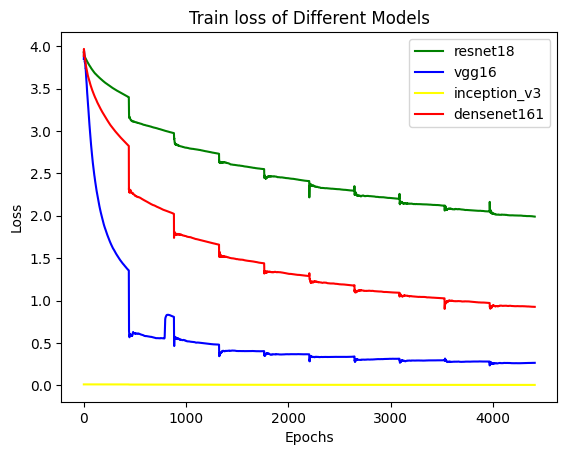

In [243]:
plt.plot(tr_loss_resnet18, color = 'green', label='resnet18')
plt.plot(tr_loss_vgg16, color = 'blue', label='vgg16')
plt.plot(tr_loss_inception_v3, color = 'yellow', label='inception_v3')
plt.plot(tr_loss_densenet161, color = 'red', label='densenet161')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss of Different Models')
plt.legend()
plt.show()

**Conclusions**\
Perhaps because of the initialization of the weights, the Inception V3 model showed the smallest train loss, but it trained quite slowly. It would be great to try changing the lr depending on the dynamics of the training. At a short distance in 10 epochs, the VGG 16 model showed the best results. More epochs are needed for deeper models.

PS: before/after fine-tunning Inception V3:

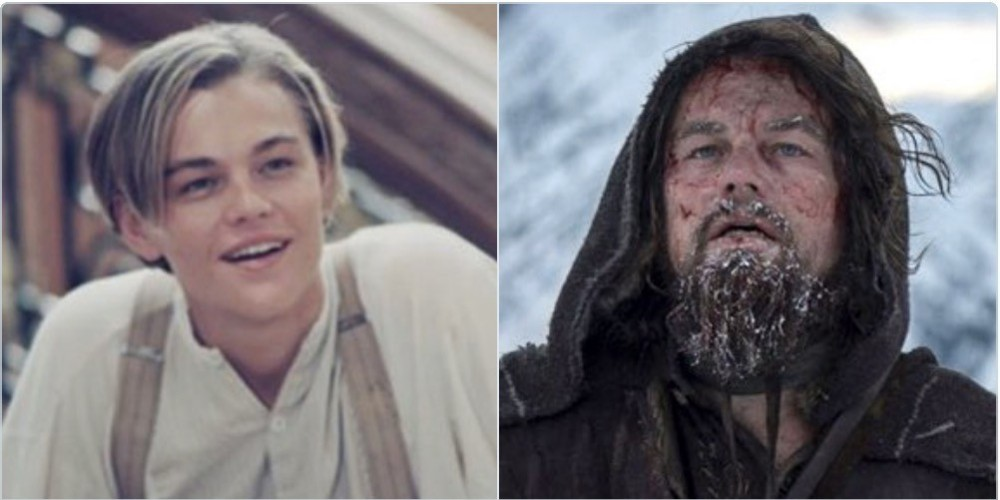